
# <span style="color:rgb(213,80,0)">Clustering 5.7 million RNA sequences of coronavirus</span>

In this demo we use CLASSIX [3] to cluster a dataset accompanying the paper [1]. The data corresponds to PaCMAP low dimensional (3D) projections of two characterisations (3-mer count and Extended Natural Vector) of about 5.7 million high coverage sequences of SARS-CoV-2 from the publicly available [GISAID database](https://gisaid.org/). The PaCMAP parameters were optimized by a search over a 3x3x3 grid, selecting the best clustering of a stratified data subsample (5% of the data).


The paper [1] also compares CLASSIX to HDBSCAN [2], with the timings and achieved adjusted Rand index (ARI) and adjusted mutual information (AMI) shown in the below table.

<p style="text-align:left">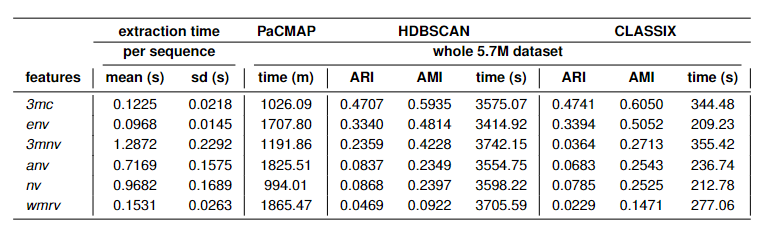</p>


Note how CLASSIX was more than 10x faster than HDSCAN and achieved better AMI on all but one instance. These timings were obtained with an old Python version of CLASSIX (0.6.5). The newer CLASSIX versions since then are even faster. [**See here for a demo of Python-CLASSIX which is more than 400 times faster than HDBSCAN for this dataset, while achieving higher ARI/AMI.**](https://github.com/nla-group/classix/blob/master/demos/Clustering_RNA_of_coronavirus.ipynb)


Let's recreate the first line in the above table using the MATLAB implementation of CLASSIX. First, we load the data together with the ground-truth labels. The data files are quite large as they contain a Python dataframe with string indices. The first execution of the below cell may take a few seconds.

## Loading the Covid3MC dataset

In [1]:
clear all
addpath ..

% Some helper functions to compute ARI and AMI
ari = @(a,b) py.sklearn.metrics.adjusted_rand_score(a,b);
ami = @(a,b) py.sklearn.metrics.adjusted_mutual_info_score(a,b);

% Load the data --
% this downloads about 300MB from the web
% and will be much faster on second run
tic
ret = py.classix.loadData('Covid3MC');
% ret{1} is a dataframe, so we first convert
% to it to an numpy array, then matlab double
df = ret{1};
data = double(df.to_numpy());
labels = double(ret{2});
toc

Elapsed time is 2.353499 seconds.

In [2]:
% min-max scale data and center data as in
% https://github.com/robcah/dimredcovid19/blob/main/Dimensionality_Reduction_Covid19.ipynb
data = data - min(data);
data = (data./max(data))-0.5;
data(1:5,:)

ans = 5x3    
    0.0859   -0.2359   -0.0636
   -0.1927   -0.1769    0.2226
    0.1446   -0.2422   -0.0122
   -0.0194   -0.2439    0.0406
   -0.0369   -0.1543   -0.3799

## CLASSIX

Now we are ready to run CLASSIX. As in [1], we use the hyperparameters <samp>radius=0.2</samp> and <samp>minPts=500</samp>.


In [3]:
% MATLAB CLASSIX
tic
[label, explain, out] = classix(data,0.2,500);
fprintf('CLASSIX.M\n  Runtime: %5.3f seconds\n  #points: %d\n  Classes: %d\n  ARI: %3.4f\n  AMI: %3.4f',...
    toc,length(label),length(unique(label)),ari(labels,label),ami(labels,label))

CLASSIX.M
  Runtime: 6.692 seconds
  #points: 5726839
  Classes: 25
  ARI: 0.4741
  AMI: 0.6050


This took less than 7 seconds! This MATLAB live script is run on a 2019 ThinkPad with Intel i7 processor and 8 GB RAM.

## Comparison with DBSCAN

We can compare this to MATLAB's DBSCAN, which turns out to be significantly slower. For a reasonable time to completion, we run DBSCAN on a subsample of 5% of the data. The DBSCAN parameters have been chosen to obtain similar ARI/AMI scores to CLASSIX's, though these scores are not directly comparable as DBSCAN works on a data subset.


In [4]:
%% MATLAB DBSCAN
%  We cluster only 5% of the data.
data_subs = data(1:20:end,:);
labels_subs = labels(1:20:end);
tic
idx = dbscan(data_subs, 0.1, 1);
fprintf('DBSCAN (5%% of data)\n  Runtime: %5.3f seconds\n  #points: %d\n  Classes: %d\n  ARI: %3.4f\n  AMI: %3.4f',...
    toc,length(idx),length(unique(idx)),ari(labels_subs,idx),ami(labels_subs,idx))

DBSCAN (5% of data)
  Runtime: 493.330 seconds
  #points: 286342
  Classes: 39
  ARI: 0.4666
  AMI: 0.6015


DBSCAN requires approximately 8 minutes to cluster 5% of the data to similar quality as CLASSIX. For the full dataset with 5.7M points, the DBSCAN runtime would be in the order of hours.

## CLASSIX's explain function

We can use CLASSIX explain functionality to get insights into why data points have been clustered together, or not. For example, the reason why data points 300 and 400 are in the same cluster #16 is that there is a path of nearby data points within cluster #16 that connects them:


Data point 300 is in group 210, which was merged into cluster #16.
Data point 400 is in group 252, which was merged into cluster #16.
Too many data points for plot. Randomly subsampled 1e5 points.
A path of overlapping groups with step size <= 1.5*R = 0.10 is:
 210 -> 224 -> 237 -> 246 -> 251 -> 252
(Note that with data having more than 2 features, the two
 group circles in the plot may appear bigger than they are.)


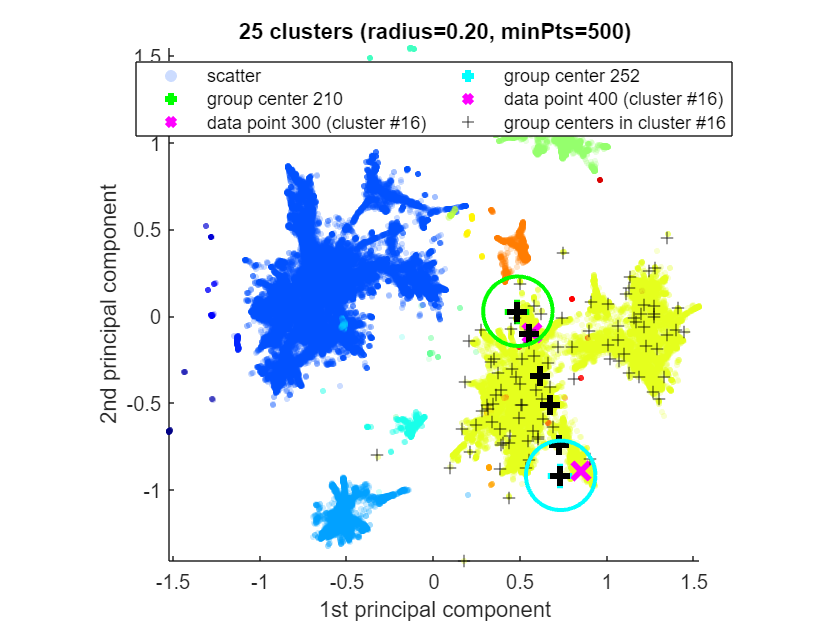

In [5]:
explain(300,400)

## Learn more about CLASSIX?

CLASSIX is a fast and memory-efficient clustering algorithm which produces explainable results. If you'd like to learn more, here are a couple of online resources:

-  arXiv paper: [https://arxiv.org/abs/2202.01456](https://arxiv.org/abs/2202.01456)
-  Python code: [https://github.com/nla-group/classix](https://github.com/nla-group/classix)
-  MATLAB code: [https://github.com/nla-group/classix-matlab/](https://github.com/nla-group/classix-matlab/)
-  YouTube video: [https://www.youtube.com/watch?v=K94zgRjFEYo](https://www.youtube.com/watch?v=K94zgRjFEYo)
## References

[1] X. Chen and S. Güttel. "Fast and explainable clustering based on sorting." arXiv: [https://arxiv.org/abs/2202.01456](https://arxiv.org/abs/2202.01456), 2022.


[2] D. Dua and C. Graff. "UCI machine learning repository." URL: [http://archive.ics.uci.edu/ml](http://archive.ics.uci.edu/ml), 2017.

